In [1]:
from pyomo.environ import *
%matplotlib qt

In [2]:
m = AbstractModel()
"""
Parameters:
  z
  |_y
 /
x
x -> Depth  D
y -> Width  W
z -> Height H
"""

m.N_value = Param(domain=PositiveIntegers)
m.W_max = Param(domain=PositiveReals)
m.H_max = Param(domain=PositiveReals)
m.D_max = Param(domain=PositiveReals)
m.N = RangeSet(m.N_value)
m.N_N = Set(initialize=m.N*m.N, filter=lambda _,i,j: i<j)

m.D = Param(m.N, domain=PositiveReals)
m.W = Param(m.N, domain=PositiveReals)
m.H = Param(m.N, domain=PositiveReals)

m.x = Var(m.N, domain=NonNegativeReals, bounds=(0,m.D_max), initialize=0)
m.y = Var(m.N, domain=NonNegativeReals, bounds=(0,m.W_max), initialize=0)
m.z = Var(m.N, domain=NonNegativeReals, bounds=(0,m.H_max), initialize=0)

m.lt = Var(domain=PositiveReals)
m.obj = Objective(expr=m.lt)

@m.Constraint(m.N)
def depth_constr(m,i):
    return m.x[i]+m.D[i] <= m.D_max

@m.Constraint(m.N)
def width_constr(m,i):
    return m.y[i]+m.W[i] <= m.W_max

@m.Constraint(m.N)
def objective_constr(m,i):
    return m.z[i]+m.H[i] <= m.lt

@m.Disjunction(m.N_N)
def direction_disjunct(m,i,j):
    return [
        m.x[i]+m.D[i] <= m.x[j],
        m.x[j]+m.D[j] <= m.x[i],
        m.y[i]+m.W[i] <= m.y[j],
        m.y[j]+m.W[j] <= m.y[i],
        m.z[i]+m.H[i] <= m.z[j],
        m.z[j]+m.H[j] <= m.z[i]
    ]

In [3]:
instance = m.create_instance('rand_params_3D.dat')
opt = SolverFactory('gdpopt')
opt.solve(instance)

{'Problem': [{'Name': 'unknown', 'Lower bound': 3.88340194011, 'Upper bound': 3.8834018877005714, 'Number of objectives': 1, 'Number of constraints': 507, 'Number of variables': 508, 'Number of binary variables': 468, 'Number of integer variables': 0, 'Number of continuous variables': 40, 'Number of nonzeros': None, 'Sense': 1, 'Number of disjunctions': 78}], 'Solver': [{'Name': 'GDPopt (19, 3, 11) - LOA', 'Status': 'ok', 'Message': None, 'User time': 2.3813563140000156, 'System time': None, 'Wallclock time': 2.3813563140000156, 'Termination condition': 'optimal', 'Termination message': None, 'Timing': Container(OA cut generation = 0.001256030000007513, initialization = 0.24169761600001038, integer cut generation = 0.008467217999992727, main loop = 1.903068735000005, main_timer_start_time = 168.909980734, mip = 1.4545782029999828, nlp = 0.4384828670000047, total = 2.3813563140000156), 'Iterations': 1}]}

In [4]:
def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import random
from itertools import product, combinations
import numpy as np

def plotBox(ax, v1, v2, **kwargs):
    for a, b in combinations(list(product(*zip(v1,v2))),2):
        if len(np.nonzero(np.array(a)-np.array(b))[0]) == 1:
            ax.plot3D(*zip(a,b), **kwargs)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
#scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
plt.title('Packing solution (w/o rotation)', fontsize=16)

ax.set_xlabel('x-axis (fixed)', fontsize=14)
ax.set_ylabel('y-axis (fixed)', fontsize=14)
ax.set_zlabel('z-axis (minimization direction)', fontsize=14)

(x,y,z) = (instance.x, instance.y, instance.z)
(D,W,H) = (instance.D, instance.W, instance.H)

plotBox(ax, (0,0,0), (instance.D_max.value, instance.W_max.value, 0), color='red',linewidth=5)

for i in instance.N:
    random.seed(i)
    random_color = [random.random() for i in range(3)]
    plotBox(ax, (x[i].value, y[i].value, z[i].value), (x[i].value+D[i], y[i].value+W[i], z[i].value+H[i]), color=random_color, linewidth=5, alpha=0.6)


set_axes_equal(ax)
plt.tight_layout()

In [156]:
#instance.direction_disjunct.pprint()
for j in range(312, 318):
    print(instance.direction_disjunct_disjuncts[j].indicator_var.value)
instance.direction_disjunct_disjuncts[317].indicator_var.value

0
0
0
0
0
1


1

In [144]:
i=8
instance.D[i],instance.W[i],instance.H[i]
#instance.x[i].value, instance.y[i].value, instance.z[i].value

(0.8678730954238538, 0.8553524746926998, 0.17083851216642043)

In [137]:
print([x[i].value for i in instance.N])
print([y[i].value for i in instance.N])
print([z[i].value for i in instance.N])
print([D[i] for i in instance.N])
print([W[i] for i in instance.N])
print([H[i] for i in instance.N])

[0.35868804529831755, 0.5688346967781601, 0.378578260862041, 0.10561614095406739, 0, 0.7839509881420373, 0.09177807846672327, 0.11104503545014155, 0.08997139514464292, 0.00213677532212406, 0.22103237246886925, 0.0022715360168249054, 0.14936663821266835]
[0.12451235389278638, 0.4585080718736123, 0.4911143440257299, 0, 0.008596823506744514, 0.15368596196200277, 0.14167231091587001, 0.11873883518304745, 0.4530900833344447, 0.5892072274202969, 0.006090882728778461, 0.14449335059696722, 0]
[1.7803742458224678, 1.567430091567662, 3.2059346516112206, 0.0, 1.1947350344159338, 0.6739564475255057, 1.6394664525209572, 0.4539384629088919, 1.8286385885060532, 0.08267305577500962, 3.547953391670594, 0.6247769675209298, 2.2347847241278522]
[0.41647784090069095, 0.42660525762084345, 0.5970762565572099, 0.8771507373803988, 0.8152109051914592, 0.21424555865230288, 0.258251123117594, 0.8678730954238538, 0.474121737693183, 0.08288609113870016, 0.6947687443417415, 0.7793840356953128, 0.8056621491039214]
[0

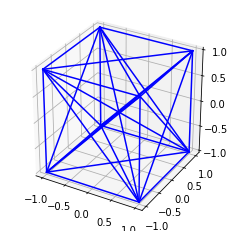

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

r = [-1,1]
for a, b in combinations(list(product(r,r,r)),2):
    ax.plot3D(*zip(a,b), c='blue')

In [181]:
instance.D_max.value

1